In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Objective

The goal of this project is to analyze the effectiveness of labels within the fanfiction website "Archives Of Our Own" (AO3) in respect to the popularity of each fanfiction. Labels are author-determined, but are heavily moderated within the website for consistency. The goal is to determine influential tags in determining popularity of works.

# Data Collection

The data here has already been collected in this case, as repeating the same collection process takes several days. The code for this can be found in other files within this repository.

In [2]:
# An array of dataframes, one for each 'fandom'
fandom_dfs = []

csv_filenames = ['mha.csv', 'haikyuu.csv', 'aot.csv', 'bsd.csv', 'danganronpa.csv', 'hetalia.csv', 'jojo.csv', 'naruto.csv', 'onepiece.csv', 'pokemon.csv']

for csv in csv_filenames:
    fandom_dfs.append(pd.read_csv('data/' + csv))

for i in range(len(fandom_dfs)):
    fandom_dfs[i] = fandom_dfs[i][['Title', 'Author', 'Kudos', 'Comments', 'Bookmarks', 'Hits', 'Tags']]

# An array of relevant tags according to AO3's open data from 2021
tag_df = pd.read_csv('data/ordered_tags_20210226.csv')

In [3]:
fandom_sizes = np.array([len(fandom) for fandom in fandom_dfs])
fandom_sizes_norm = fandom_sizes/fandom_sizes.sum()
fandom_sizes_norm

array([0.2013485 , 0.20138878, 0.08525592, 0.07012156, 0.07234892,
       0.06721955, 0.06058983, 0.11962292, 0.06018705, 0.06191698])

# Data Cleaning

This section is meant to prune the tags to tags that are a) popular and b) universal (not media-specific).

Notably, My Hero Academia is perhaps the most popular category in this site and has a lot of tags that only relate to My Hero Academia and its characters.

In [4]:
# returns (true, canon name) if in database, and (false, none) else
def inDatabase(name):
    current = name
    while True:
        index = tag_df["name"].searchsorted(current)
        if current != tag_df["name"].iloc[index]:
            return (False, None)
        
        if tag_df['canonical'].iloc[index]:
            return (True, tag_df['name'].iloc[index])
        
        if pd.isna(tag_df['merger_id'].iloc[index]):
            return (False, None)
        
        current = tag_df['name'].iloc[int(tag_df['merger_id'].iloc[index])]
        
# Generates a list of tags that have canonical names
def find_canonical_tags(tags):
    tags = tags[2:-2].split('], [')
    found_tags = []
    if tags[0] == '':
        return found_tags
    for tag in tags:
        pair = tag.split(', ')
        name = pair[0][1:-1]
        link = pair[1][1:-1]
        in_database, canonical = inDatabase(name)
        if in_database:
            found_tags.append(canonical)
            
    return found_tags

# Generates a listof tags that do not have a canonical name
def find_missing_tags(tags):
    unfound_tags = []
    if tags[0] == '':
        return unfound_tags
    for tag in tags:
        pair = tag.split(', ')
        name = pair[0][1:-1]
        link = pair[1][1:-1]
        in_database, canonical = inDatabase(name)
        if not in_database:
            unfound_tags.append((False, name, link))
            
    return unfound_tags

## Tags without a Common Name

Most tags have a common name that they all route to. This is AO3's way of keeping their tagging system organized and compact. Tags that don't really add to the description of the work don't have this routing, although sometimes relevant tags are unmarked, since this is done by hand. 

As the list of common names, called "canonical names", is pulled from a 2021 dataset of tags provided by AO3 themselves, this section aimed to determine whether it was worth seeing if any of the tags have since been updated.

After manually examining the list of the most frequent tags within this category, it was ultimately decided that it would be best to ignore tags not included in the 2021 dataset.

In [5]:
# missing_tags_all = []
# for fandom_df in fandom_dfs:
#     missing_tags = {}
#     for i in range(fandom_df.shape[0]):
#         unfound = find_missing_tags(fandom_df.iloc[i]['Tags'][2:-2].split('], ['))
#         for _, name, link in unfound:
#             if name in missing_tags:
#                 missing_tags[name][1] += 1
#             else:
#                 missing_tags[name] = [link, 1]
                
#     missing_tags_all.append(missing_tags)

# for group in missing_tags_all:
#     print(len(group))

In [6]:
# missing_tags_counter = {}
# for i in range(len(missing_tags_all)):
#     for name, data in missing_tags_all[i].items():
#         if name not in missing_tags_counter:
#             missing_tags_counter[name] = [0 for i in range(len(missing_tags_all))]
#         missing_tags_counter[name][i] = 1

# min_thresh = 10
# for i in range(2, 11):
#     repeated_tags = 0
#     for tag, counters in missing_tags_counter.items():
#         if sum(counters) >= i:
#             repeated_tags += 1
        
#     print(f'{i}: {repeated_tags}')

## Tags with Common Names

In [7]:
for fandom_df in fandom_dfs:
    fandom_df['Tags'] = fandom_df['Tags'].apply(find_canonical_tags)

In [8]:
tags_per_fandom = []
for fandom_df in fandom_dfs:
    tags = set()
    for i in range(fandom_df.shape[0]):
        tags.update(fandom_df.iloc[i]['Tags'])
    
    tags_per_fandom.append(tags)
    print(len(tags))

10826
8811
7450
5384
5842
5861
5850
6741
5088
5429


In [9]:
tag_spread_counter = {}
for i in range(len(tags_per_fandom)):
    for tag in tags_per_fandom[i]:
        if tag not in tag_spread_counter:
            tag_spread_counter[tag] = [0 for i in range(len(tags_per_fandom[i]))]
            
        tag_spread_counter[tag][i] = 1

In [10]:
tag_frequencies = []
tag_frequencies_min = []
for i in range(1, 11):
    repeated_tags = 0
    repeated_tags_min = 0
    for tag, counters in tag_spread_counter.items():
        if sum(counters) == i:
            repeated_tags += 1
        if sum(counters) >= i:
            repeated_tags_min += 1
            
    tag_frequencies.append(repeated_tags)
    tag_frequencies_min.append(repeated_tags_min)
    
print(tag_frequencies)
print(tag_frequencies_min)

[14627, 1239, 781, 640, 568, 508, 530, 570, 684, 2496]
[22643, 8016, 6777, 5996, 5356, 4788, 4280, 3750, 3180, 2496]


## Refactor Metrics

The extraction algorithm used the number -1 to represent a value that was missing. However, it appears that the website hides metrics that are valued at zero, meaning that every occurence of -1 is actually supposed to be a 0.

In [12]:
for fandom_df in fandom_dfs:
    print(len(fandom_df))
    display(fandom_df[fandom_df == -1].sum(axis = 0))
    

99980


Title             0
Author            0
Kudos           0.0
Comments    -3154.0
Bookmarks    -193.0
Hits            0.0
Tags              0
dtype: object

100000


Title              0
Author             0
Kudos            0.0
Comments    -18473.0
Bookmarks   -12452.0
Hits             0.0
Tags               0
dtype: object

42334


Title              0
Author             0
Kudos         -549.0
Comments    -11539.0
Bookmarks    -9191.0
Hits             0.0
Tags               0
dtype: object

34819


Title             0
Author            0
Kudos        -295.0
Comments    -9052.0
Bookmarks   -6352.0
Hits            0.0
Tags              0
dtype: object

35925


Title             0
Author            0
Kudos        -429.0
Comments    -8165.0
Bookmarks   -7322.0
Hits            0.0
Tags              0
dtype: object

33378


Title              0
Author             0
Kudos         -937.0
Comments    -14353.0
Bookmarks   -12268.0
Hits             0.0
Tags               0
dtype: object

30086


Title             0
Author            0
Kudos        -413.0
Comments    -9063.0
Bookmarks   -7107.0
Hits            0.0
Tags              0
dtype: object

59399


Title              0
Author             0
Kudos        -1020.0
Comments    -15228.0
Bookmarks   -11816.0
Hits             0.0
Tags               0
dtype: object

29886


Title             0
Author            0
Kudos        -289.0
Comments    -7576.0
Bookmarks   -5411.0
Hits            0.0
Tags              0
dtype: object

30745


Title              0
Author             0
Kudos        -1420.0
Comments    -10438.0
Bookmarks    -9458.0
Hits             0.0
Tags               0
dtype: object

In [13]:
filtered_dfs = []
for fandom_df in fandom_dfs:
    filtered_df = fandom_df.copy()
    filtered_df.loc[fandom_df['Kudos'] == -1,'Kudos'] = 0
    filtered_df.loc[fandom_df['Comments'] == -1,'Comments'] = 0
    filtered_df.loc[fandom_df['Bookmarks'] == -1,'Bookmarks'] = 0
    filtered_df.loc[fandom_df['Hits'] == -1,'Hits'] = 0
    filtered_dfs.append(filtered_df)

In [14]:
for filtered_df in filtered_dfs:
    print(len(filtered_df))

99980
100000
42334
34819
35925
33378
30086
59399
29886
30745


## Tag Filtering

Tag filtering is composed of the following parts:
1. Calculate number of occurences for each tag
2. Calculate spread of each tag over all fandoms
3. Remove tags that do not meet thresholds
4. Remove data without any tags

Additionally, data regarding tag metrics will be collected, but not used in the filtering process.

In [15]:
min_occurences = 100
min_fandom_occurences = 2
min_perc_thresh = 0.5

In [16]:
# Each stat is an array of 11 numbers
# 0-9 for each fandom, 10 represents the total
# Stats: [name, count, kudos, comments, bookmarks, hits]
tag_stats_dict = {}
count_ind = 1
kudo_ind = 12
comment_ind = 23
bookmark_ind = 34
hit_ind = 45

for i in range(len(filtered_dfs)):
    df = filtered_dfs[i]
    for j in range(df.shape[0]):
        work = df.iloc[j]
        for tag in work.Tags:
            if tag not in tag_stats_dict:
                tag_stats_dict[tag] = [0] 
                for _ in range(5):
                    tag_stats_dict[tag].append([0 for x in range(len(filtered_dfs))])
                    tag_stats_dict[tag].append(0)
                tag_stats_dict[tag][0] = tag

            tag_stats_dict[tag][1][i] += 1
            tag_stats_dict[tag][2] += 1
            tag_stats_dict[tag][3][i] += work.Kudos
            tag_stats_dict[tag][4] += work.Kudos
            tag_stats_dict[tag][5][i] += work.Comments
            tag_stats_dict[tag][6] += work.Comments
            tag_stats_dict[tag][7][i] += work.Bookmarks
            tag_stats_dict[tag][8] += work.Bookmarks
            tag_stats_dict[tag][9][i] += work.Hits
            tag_stats_dict[tag][10] += work.Hits

            
    
#     tags_per_fandom.append(tags)
#     print(len(tags))

In [17]:
def fandom_appearances(counts):
    total_counts = 0
    for count in counts:
        total_counts += count
        
    total = 0
    for i in range(len(counts)):
        threshold = total_counts * fandom_sizes_norm[i] * min_perc_thresh
        if counts[i] > threshold:
            total += 1
    return total     

tag_stats = list(tag_stats_dict.values())
filtered_tags_df = pd.DataFrame(tag_stats, columns = ['Name', 'Count', 'Total Count', 'Kudos', 'Total Kudos', 'Comments', 'Total Comments', 'Bookmarks', 'Total Bookmarks', 'Hits', 'Total Hits'])
    
filtered_tags_df['Spread'] = filtered_tags_df['Count'].apply(fandom_appearances)
# filtered_tags_df

In [18]:
filtered_tags_df = filtered_tags_df[filtered_tags_df['Spread'] >= 5]
print(len(filtered_tags_df))
filtered_tags_df = filtered_tags_df[filtered_tags_df['Total Count'] > 500]
# print(len(filtered_tags_df))
# view = filtered_tags_df[filtered_tags_df['Spread'] == 4]
# display(len(view))
# for name in filtered_tags_df['Name'].values:
#     print(name)

4944


In [19]:
tagnames_unfiltered = ['Alternate Universe - Canon Divergence', 'Queerplatonic Relationships', 'Panic Attacks', 'Trauma', 'Body Horror', 'Character Death', 'Temporary Character Death', 'Implied/Referenced Child Abuse', 'Misunderstandings', 'Bullying', 'Angst with a Happy Ending', 'Love Confessions', 'Emotional Hurt/Comfort', 'Mutual Pining', 'Spoilers', 'Emotional Manipulation', 'Betrayal', 'Suicidal Thoughts', 'Self-Hatred', 'Angst', 'Slow Burn', 'Eventual Romance', 'Murder', 'Human Experimentation', 'Secrets', 'Secret Identity', 'Crack Treated Seriously', 'My First AO3 Post', 'Fluff', 'Implied/Referenced Suicide', 'Crack', 'Fluff and Humor', 'Fluff and Angst', 'Emotional Hurt', 'It Gets Worse Before It Gets Better', 'Dissociation', 'Families of Choice', 'Past Child Abuse', 'Hurt/Comfort', 'Canon-Typical Violence', 'Whump', 'Ghosts', 'Mythical Beings & Creatures', 'Language', 'Anxiety Attacks', 'Nightmares', 'Cuddling & Snuggling', 'Kissing', 'First Kiss', 'Pining', 'Friends to Lovers', 'Recovery', 'Alternate Universe - Soulmates', 'Child Abuse', 'Self-Harm', 'Humor', 'Friendship', 'Enemies to Friends to Lovers', 'Blood and Injury', 'Post-Traumatic Stress Disorder - PTSD', 'Character Development', 'Developing Relationship', 'Therapy', 'Sharing a Bed', 'Miscommunication', 'Near Death Experiences', 'Character Study', 'Soulmate-Identifying Marks', 'Author Is Sleep Deprived', 'Time Loop', 'Domestic Fluff', 'Established Relationship', 'Phone Calls & Telephones', 'Family Fluff', 'Mystery', 'Self-Esteem Issues', 'Mental Health Issues', 'Implied/Referenced Alcohol Abuse/Alcoholism', 'Unreliable Narrator', 'Swearing', 'Minor Violence', 'Comedy', 'Drabble Collection', 'Anxiety', 'Torture', 'Violence', 'Bodyswap', 'One Shot Collection', 'Feelings', 'Family', 'Social Anxiety', 'Not Beta Read', 'Fake/Pretend Relationship', 'Literal Sleeping Together', 'Physical Abuse', 'Underage Drinking', 'Minor Original Character(s)', 'Manipulation', 'Pain', 'References to Depression', 'Light Angst', 'Minor Character Death', "I'm Sorry", 'POV Outsider', 'Happy Ending', 'Fluff and Hurt/Comfort', 'Short', 'Drabble', 'High School', 'Trust Issues', 'Childhood Trauma', 'Age Regression/De-Aging', 'Platonic Relationships', 'Secret Santa', 'Angst and Hurt/Comfort', 'Implied/Referenced Self-Harm', "This Is Why We Can't Have Nice Things", 'Alternate Universe', 'Pranks and Practical Jokes', 'Fluff and Crack', 'Why Did I Write This?', 'Unresolved Sexual Tension', 'Canon Universe', 'Cats', 'Bonding', 'Movie Night', 'Sleepovers', 'Fanart', 'Texting', 'Chatting & Messaging', 'Injury Recovery', 'Major Character Injury', 'Unhealthy Relationships', 'Gay Panic', 'Roommates', 'Running Away', 'Other Additional Tags to Be Added', 'Rating May Change', 'Stalking', "Additional Warnings In Author's Note", 'Alternate Universe - Royalty', 'Alternate Universe - Fantasy', 'Angst and Humor', 'Day At The Beach', 'How Do I Tag', 'Action/Adventure', 'Insecurity', 'Insomnia', 'Fix-It of Sorts', 'Mild Language', 'I Wrote This Instead of Sleeping', 'The Author Regrets Everything', 'Implied/Referenced Character Death', 'Hopeful Ending', 'Not Canon Compliant', 'Homophobia', 'Coming Out', 'LGBTQ Themes', 'Cross-Posted on Tumblr', 'Tags May Change', 'Mild Gore', 'Bittersweet Ending', 'Original Character(s)', 'Canon Compliant', 'Romantic Comedy', 'Post-Canon', 'Confessions', 'Some Humor', 'Holding Hands', 'Mild Blood', 'Worldbuilding', 'Pre-Canon', 'Marriage', "I Don't Even Know", 'Slow Build', 'Suicide', 'Depression', 'No Spoilers', 'Crushes', 'Redemption', 'Polyamory', 'Kidnapping', 'Injury', 'Hurt', 'Crying', 'Alternate Universe - Time Travel', 'Suicide Attempt', 'Grief/Mourning', 'Idiots in Love', 'Adoption', 'Emotional/Psychological Abuse', 'Child Neglect', 'Eventual Happy Ending', 'Hijinks & Shenanigans', 'Alternate Universe - No Powers', 'Alternate Universe - College/University', 'Trans Male Character', 'Alternate Universe - Coffee Shops & Cafés', 'Mild Hurt/Comfort', 'Attempt at Humor', 'Secret Relationship', 'Ambiguous/Open Ending', 'One Shot', 'Pre-Relationship', 'Cute', 'Implied/Referenced Homophobia', 'Nonbinary Character', 'Slow Dancing', 'Feelings Realization', 'Male-Female Friendship', 'Scars', 'Hanahaki Disease', 'Unrequited Love', 'Team as Family', 'Tooth-Rotting Fluff', 'Emotional Baggage', 'Family Issues', 'Birthday', 'Triggers', 'The Author Regrets Nothing', 'Platonic Soulmates', 'Minor Injuries', 'Platonic Cuddling', 'Family Feels', 'Tags Contain Spoilers', 'Angst and Feels', 'Light-Hearted', 'POV Alternating', 'POV Third Person', 'Background Relationships', 'Amnesia', 'Alternate Universe - Harry Potter Setting', 'Romance', 'Drama', 'Implied/Referenced Torture', 'Memory Loss', 'Reunions', 'Childhood Friends', 'Ficlet', 'Touch-Starved', 'Past Abuse', 'My First Fanfic', 'Feels', 'Heavy Angst', 'Romantic Soulmates', 'Oblivious', 'Blushing', 'Caretaking', 'Introspection', 'Non-Sexual Intimacy', 'Everyone Needs A Hug', 'Halloween', 'Guilt', 'Training', 'Action', 'Death', 'Hurt No Comfort', 'Unhappy Ending', 'Sad', 'Boys In Love', 'Implied/Referenced Abuse', 'What Have I Done', 'Sorry Not Sorry', 'Blood and Violence', 'Psychological Trauma', 'Survivor Guilt', 'Slow Romance', 'Sick Character', 'Self-Doubt', 'POV Multiple', 'Implied Relationships', 'Complete', 'Enemies to Friends', 'Best Friends', 'Kid Fic', "I'm Bad At Tagging", 'Ambiguous Relationships', 'Non-Graphic Violence', 'Out of Character', 'Hospitals', 'Bad Parenting', 'Revenge', 'Anger', 'Pre-Slash', 'Developing Friendships', 'Drama & Romance', 'Baking', 'Romantic Fluff', 'Blood and Gore', 'Alternate Universe - Roommates/Housemates', 'Domestic', 'Everyone Is Gay', 'Long-Distance Relationship', 'Implied Sexual Content', 'Making Out', 'Comfort', 'Dorks in Love', 'Slice of Life', 'Alternate Universe - Future', 'Arranged Marriage', 'Hospitalization', 'Canon Rewrite', 'Genderbending', 'Dreams', 'Father-Son Relationship', 'Family Bonding', 'Tags Are Hard', 'Rain', 'Drowning', 'Jealousy', 'Self-Worth Issues', 'Hallucinations', 'Angst and Tragedy', 'Blood', 'Перевод на русский | Translation in Russian', 'Fear', 'Reader-Insert', 'Love Triangles', 'Teen Romance', 'Vampires', 'Chaos', 'Slow To Update', 'Soulmates', 'What-If', 'Parenthood', 'Christmas', 'No Angst', 'Smut', 'Fix-It', 'Help', 'Summer', 'Self-Indulgent', 'Regret', 'Healing', 'Self-Discovery', 'Alternate Universe - Canon', 'Flashbacks', 'Sibling Bonding', 'Abuse', 'Awkward Conversations', 'Couch Cuddles', 'Unhealthy Coping Mechanisms', 'True Love', 'Alternate Universe - Gods & Goddesses', 'Coffee Shops', 'No Romance', 'Trans Female Character', 'Explicit Language', 'Married Life', 'Mental Breakdown', 'Alternate Universe - Flower Shop', 'Language of Flowers', 'Protectiveness', 'Self-Insert', 'Cooking', 'Canon Related', 'Marriage Proposal', 'Emotional', 'Gender Dysphoria', 'Apologies', 'Late Night Conversations', 'Coffee', 'Red String of Fate', 'Gift Fic', 'Headcanon', 'Mpreg', 'Sharing Clothes', 'Falling In Love', 'First Dates', 'Omega Verse', 'Alpha/Beta/Omega Dynamics', 'Alpha/Omega', 'Non-Traditional Alpha/Beta/Omega Dynamics', 'Flirting', 'Teasing', 'Banter', 'Alcohol', 'Sexual Tension', 'Fights', 'Bickering', 'Fantasy', 'Dancing', 'Weddings', 'Drinking', 'Awkward Romance', 'Alcohol Abuse/Alcoholism', 'Music', 'Dark', 'Alternate Universe - Childhood Friends', "Valentine's Day", 'Eventual Fluff', 'Forbidden Love', 'Sickfic', 'Implied/Referenced Rape/Non-con', 'Dysfunctional Family', 'Love at First Sight', 'Boys Kissing', 'Alternate Universe - High School', 'Strangers to Lovers', 'Asexual Character', 'Tumblr Prompt', 'Fluff without Plot', 'Forehead Kisses', 'Merpeople', 'Married Couple', 'Possessive Behavior', 'Eventual Smut', 'Age Difference', 'Alternate Universe - Magic', 'Sad Ending', 'Hugs', 'Implied/Referenced Drug Use', 'Dreams and Nightmares', 'First Meetings', 'First Time', 'Dogs', 'Alternate Universe - Different First Meeting', 'Healthy Relationships', 'Dialogue Heavy', "I Can't Believe I Wrote This", 'Post-Break Up', 'Reincarnation', 'I Tried', 'Canonical Character Death', 'Self Confidence Issues', 'Unresolved Romantic Tension', 'Childhood Memories', 'Comfort/Angst', 'Mental Instability', 'Smoking', 'Original Character Death(s)', 'Drug Use', 'Short One Shot', 'Family Drama', 'Christmas Fluff', 'Holidays', 'Mistletoe', 'Tragedy', 'Declarations Of Love', 'Denial of Feelings', 'Implied/Referenced Sex', 'Letters', 'POV First Person', 'Vomiting', 'Truth or Dare', 'Domestic Bliss', 'Mild Sexual Content', 'Brotherly Love', 'Sad with a Happy Ending', 'Love', 'Warm and Fuzzy Feelings', 'Sleepy Cuddles', 'Cute Ending', 'Fluffy Ending', 'Alternate Universe - Hogwarts', 'Alternate Universe - Reincarnation', 'No Plot/Plotless', 'Sweet', 'Other Ships Not Mentioned in Tags', 'Beaches', 'Recreational Drug Use', 'Ice Skating', 'Funny', 'Childhood', 'Cross-Posted on Wattpad', 'Gay', 'Happy', 'Tattoos', "I'm Bad At Summaries", 'This Is STUPID', 'No Sex', 'No Smut', 'Trans Character', 'Singing', 'Cute Kids', 'Song Lyrics', 'Fluff and Smut', 'Siblings', 'Abandoned Work - Unfinished and Discontinued', 'My First Work in This Fandom', 'Alternate Universe - Gender Changes', 'Alternate Canon', 'Dating', 'Awkward Flirting', 'Transphobia', 'Gender-Neutral Pronouns', 'Time Skips', 'Family Dynamics', 'Cheating', 'Cross-Posted on FanFiction.Net', 'Conversations', 'Rivalry', 'Pregnancy', 'Awkwardness', 'Alternate Universe - Supernatural Elements', 'Tickling', 'Eventual Relationships', 'Politics', 'Coming of Age', 'Growing Up', 'Complicated Relationships', 'Internalized Homophobia', 'Lowercase', 'Eating Disorders', 'Not Actually Unrequited Love', 'Parody', 'Alternate Universe - Vampire', 'Heartbreak', 'Illnesses', 'Bittersweet', 'Demons', 'Bad Flirting', 'Embarrassment', 'Sexual Humor', 'Teacher-Student Relationship', 'Prompt Fic', 'Gore', 'Road Trips', 'Supernatural Elements', 'Getting to Know Each Other', 'Drunkenness', 'Food', 'Backstory', 'Friendship/Love', 'Everybody Lives', 'Love Letters', 'Unrequited Crush', 'Arguing', 'Unplanned Pregnancy', 'Past Character Death', 'Sex', 'Gift Giving', 'Boyfriends', 'Enemies to Lovers', 'Past Relationship(s)', 'Non-Sexual Age Play', 'Lesbian Character', 'Birthday Fluff', 'Birthday Presents', 'I Made Myself Cry', 'Inspired by Music', 'War', 'Comfort No Hurt', 'Non-Linear Narrative', 'Horror', 'Snow', 'Yandere', 'Magic', 'Men Crying', 'I Will Go Down With This Ship', 'Alternate Universe - Everyone Lives/Nobody Dies', 'Alternate Universe - Modern with Magic', 'Secret Crush', 'Bathing/Washing', 'Moving On', 'Break Up', 'Party', 'Lazy Mornings', 'Awkward Crush', 'Memories', 'Art', 'Angst and Romance', 'Implied/Referenced Cheating', 'Short & Sweet', 'Songfic', 'Winter', 'Rare Pairings', 'Friends With Benefits', 'POV Second Person', 'Drunken Confessions', 'Teenagers', 'Relationship Study', 'Pet Names', 'Loneliness', "Valentine's Day Fluff", 'Manga & Anime', 'Love/Hate', 'Loss', 'One-Sided Attraction', 'Silly', 'Prompt Fill', 'Crossdressing', 'Digital Art', 'Work In Progress', 'Fever', 'Meet-Cute', 'Stargazing', 'First Love', 'Gentle Kissing', 'Anal Sex', 'Sleeping Together', 'Suggestive Themes', 'Blow Jobs', 'Babies', 'Children', 'Alternate Universe - Merpeople', 'Random & Short', 'Fanfiction', 'No Dialogue', "Boys' Love", 'Yaoi', 'Talking', 'Engagement', 'During Canon', 'Flowers', 'Morning Cuddles', 'Oral Sex', 'Missing Scene', 'One-Sided Relationship', 'Adventure', 'Alternate Universe - Medieval', 'Car Accidents', 'Reminiscing', 'Podfic', 'Alternate Universe - Superheroes/Superpowers', "New Year's Eve", 'Relationship(s)', 'Plot What Plot/Porn Without Plot', 'Father-Daughter Relationship', 'Poetry', 'Originally Posted on Tumblr', 'Modern Era', 'Afterlife', 'Alternate Universe - Historical', 'Español | Spanish']
tagnames_ignore = ['Abandoned Work - Unfinished and Discontinued', 'Cross-Posted on FanFiction.Net', 'I Tried', 'The Author Regrets Everything', 'I Wrote This Instead of Sleeping', 'Originally Posted on Tumblr', 'Sorry Not Sorry', 'Manga & Anime', 'Other Additional Tags to Be Added', 'Lowercase', 'Cross-Posted on Wattpad', 'My First AO3 Post', 'Tags Contain Spoilers', "I Can't Believe I Wrote This", 'Español | Spanish', "This Is Why We Can't Have Nice Things", 'What Have I Done', 'Not Beta Read', 'Fanfiction', 'Why Did I Write This?', "Additional Warnings In Author's Note", 'Перевод на русский | Translation in Russian', 'Cross-Posted on Tumblr', 'The Author Regrets Nothing', "I'm Bad At Summaries", 'My First Work in This Fandom', 'Slow To Update', 'This Is STUPID', 'Author Is Sleep Deprived', 'Tags May Change', 'How Do I Tag', 'I Will Go Down With This Ship', 'Other Ships Not Mentioned in Tags', 'Work In Progress', 'My First Fanfic', "I'm Bad At Tagging", "I'm Sorry", "I Don't Even Know"]
tagnames_unfiltered = set(tagnames_unfiltered)
tagnames_ignore = set(tagnames_ignore)
tagnames_keep = tagnames_unfiltered - tagnames_ignore

print(len(tagnames_unfiltered))
print(len(tagnames_ignore))
print(len(tagnames_keep))

625
38
587


In [20]:
# display(fandom_dfs[0].head(25))
def find_filtered_tags(tags):
    filtered_tags = []
    for tag in tags:
        if tag in tagnames_keep:
            filtered_tags.append(tag)
            
    return filtered_tags

for filtered_df in filtered_dfs:
    filtered_df['Tags'] = filtered_df['Tags'].apply(find_filtered_tags)
    print(len(filtered_df))
    
# filtered_dfs[0].head(25)

99980
100000
42334
34819
35925
33378
30086
59399
29886
30745


In [21]:
sum = 0
for filtered_df in filtered_dfs:
    display(len(filtered_df[filtered_df['Tags'].apply(lambda x: len(x)) != 0]))

87226

85702

33564

28875

29408

21489

21862

44420

22973

22667

In [55]:
def in_tagnames_keep(tag):
    return tag in tagnames_keep

filtered_tags_df = filtered_tags_df.iloc[filtered_tags_df['Name'].apply(in_tagnames_keep).values]

filtered_tags_df.reset_index(drop=True, inplace=True)

filtered_tags_df.head(10)

,Name,Count,Total Count,Kudos,Total Kudos,Comments,Total Comments,Bookmarks,Total Bookmarks,Hits,Total Hits,Spread
0,Alternate Universe - Canon Divergence,"[6648, 2456, 1711, 1654, 1868, 92, 1443, 6009,...",25108,"[5559155, 463251, 219324, 310376, 255720, 3586...",10089060,"[914535, 52440, 29493, 28309, 56320, 643, 3023...",1533514,"[1112736, 68015, 36562, 42074, 27675, 329, 224...",1955635,"[93309455, 5188600, 3563130, 3683255, 4581961,...",159410364,8
1,Queerplatonic Relationships,"[244, 145, 20, 31, 22, 11, 17, 44, 31, 26]",591,"[297073, 40537, 4878, 4151, 1619, 720, 1268, 9...",367018,"[60525, 4841, 412, 244, 296, 147, 427, 1277, 5...",69042,"[60704, 8248, 629, 358, 173, 93, 147, 2353, 97...",73788,"[6712677, 579104, 45992, 50222, 25002, 14471, ...",7685592,7
2,Panic Attacks,"[2444, 949, 207, 362, 471, 80, 183, 229, 198, ...",5431,"[1984564, 242119, 27577, 103773, 72296, 4718, ...",2695071,"[258095, 28228, 3934, 9239, 9883, 1511, 3373, ...",363322,"[353364, 31094, 3792, 12676, 6540, 528, 3552, ...",457443,"[31828241, 3477553, 492070, 1418068, 1030152, ...",43112972,7
3,Trauma,"[724, 142, 174, 168, 315, 64, 174, 261, 149, 235]",2406,"[534367, 22481, 14578, 27883, 40912, 3067, 220...",797465,"[82437, 5050, 3259, 2906, 6677, 785, 3935, 118...",128491,"[102992, 2872, 1956, 3593, 4478, 310, 2454, 15...",145063,"[9183057, 377023, 278573, 389931, 610082, 5032...",13290588,8
4,Body Horror,"[300, 47, 43, 50, 58, 36, 111, 81, 53, 131]",910,"[276657, 5433, 2634, 5469, 7280, 1725, 11310, ...",374585,"[66173, 858, 404, 561, 2875, 295, 4131, 8336, ...",88666,"[59479, 814, 453, 650, 805, 222, 1486, 11406, ...",79009,"[5888778, 70819, 48484, 56024, 197493, 28785, ...",7678087,9
5,Character Death,"[1445, 1188, 992, 774, 735, 394, 394, 830, 328...",7381,"[779938, 84208, 63085, 63999, 58610, 12614, 24...",1257107,"[145822, 12140, 9567, 5717, 9388, 1980, 3678, ...",218528,"[148687, 10350, 7667, 6396, 5304, 1118, 2465, ...",212804,"[15451000, 1451736, 1293342, 842496, 974795, 2...",23726169,10
6,Temporary Character Death,"[380, 101, 32, 70, 52, 77, 64, 92, 76, 67]",1011,"[352307, 11810, 2960, 10828, 7953, 4075, 7928,...",462929,"[63073, 1828, 316, 1595, 1318, 675, 1993, 3383...",82783,"[75075, 1986, 411, 1307, 1027, 468, 964, 4715,...",94659,"[7189473, 153217, 43043, 128544, 108170, 54837...",8775957,8
7,Implied/Referenced Child Abuse,"[4150, 383, 123, 624, 500, 81, 447, 356, 241, ...",7240,"[3451576, 103734, 26287, 173447, 54439, 4933, ...",4179309,"[389243, 17767, 4700, 15549, 8522, 1102, 11450...",493892,"[590011, 14122, 5153, 25064, 4732, 555, 12876,...",707429,"[49748855, 1656033, 412070, 2206076, 788399, 8...",59928122,6
8,Misunderstandings,"[1444, 1047, 158, 188, 147, 131, 134, 329, 171...",3845,"[1062036, 339306, 32735, 55483, 24457, 12203, ...",1753517,"[93011, 24580, 4368, 3835, 3330, 1298, 3782, 1...",157452,"[175775, 47666, 4708, 6854, 2246, 1268, 2755, ...",277054,"[11795810, 3463378, 445489, 572128, 320399, 17...",19787538,8
9,Bullying,"[2115, 581, 182, 48, 304, 100, 87, 146, 42, 136]",3741,"[2238703, 183547, 25688, 9743, 41108, 6347, 10...",2563151,"[222099, 17878, 3634, 1314, 7662, 978, 2342, 4...",264153,"[406996, 24468, 3081, 955, 3508, 484, 959, 622...",448688,"[29573293, 2373268, 461169, 150665, 655532, 10...",34247745,5


# Data Visualization

Kudos are synonymous to likes, hits are synonymous to views.

We would like to examine how our filtered set of tags are distributed in terms of average popularity. However, this is difficult to do when there are multiple categories of media with varying popularities. filtered_tags_df contains the raw totals of each popularity metric, and from there, we can calculate a more balanced overall metric based on the the distributions of each anime/manga compared to the total media samples.

In [81]:
np.seterr(invalid='ignore')
filtered_tags_averages_df = pd.DataFrame()
filtered_tags_averages_df['Name'] = filtered_tags_df['Name']
filtered_tags_averages_df['Count'] = filtered_tags_df['Count']
filtered_tags_averages_df['Total Count'] = filtered_tags_df['Total Count']
texts = ['Kudos', 'Comments', 'Bookmarks', 'Hits']
for text in texts:
    filtered_tags_averages_df[f'Average {text}'] = filtered_tags_df[[f'{text}', 'Count']].apply(lambda x: np.nan_to_num(np.array(x[0])/np.array(x[1])), axis = 1)
    filtered_tags_averages_df[f'Overall Average {text}'] = filtered_tags_averages_df[f'Average {text}'].apply(lambda x: np.average(np.array(x), weights = np.array(fandom_sizes_norm)))
numbered_columns = filtered_tags_averages_df[['Overall Average Kudos', 'Overall Average Comments', 'Overall Average Bookmarks', 'Overall Average Hits']]
display(numbered_columns.describe())
print('Median values:')
display(numbered_columns.median())

,Overall Average Kudos,Overall Average Comments,Overall Average Bookmarks,Overall Average Hits
count,587.000000,587.000000,587.000000,587.000000
mean,222.577058,27.450150,33.290328,3147.956388
std,71.459614,15.429152,16.098510,1302.769064
min,52.624616,5.057398,7.429468,865.168582
25%,174.435269,16.993085,22.285339,2237.742600
50%,212.396635,23.479084,30.238714,2852.443764
75%,257.442070,33.356944,40.222096,3805.838025
max,658.491242,105.904556,121.769751,9083.886549


Median values:


Overall Average Kudos         212.396635
Overall Average Comments       23.479084
Overall Average Bookmarks      30.238714
Overall Average Hits         2852.443764
dtype: float64

Here we plot the distribution of each popularity metric.

In [95]:
avg_kudos = []
avg_comments = []
avg_bookmarks = []
avg_hits = []
counts = []

for i in range(len(filtered_tags_df)):
    avg_kudos.append(filtered_tags_df.iloc[i]['Total Kudos']/filtered_tags_df.iloc[i]['Total Count'])
    avg_comments.append(filtered_tags_df.iloc[i]['Total Comments']/filtered_tags_df.iloc[i]['Total Count'])
    avg_bookmarks.append(filtered_tags_df.iloc[i]['Total Bookmarks']/filtered_tags_df.iloc[i]['Total Count'])
    avg_hits.append(filtered_tags_df.iloc[i]['Total Hits']/filtered_tags_df.iloc[i]['Total Count'])
    counts.append(filtered_tags_df.iloc[i]['Total Count'])

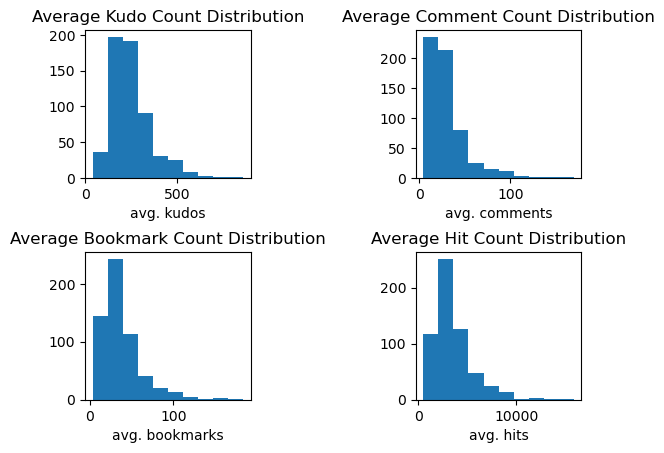

In [96]:
plt.subplot(2, 2, 1)
plt.hist(avg_kudos)
plt.title('Average Kudo Count Distribution')
plt.xlabel('avg. kudos')
plt.subplot(2, 2, 2)
plt.hist(avg_comments)
plt.title('Average Comment Count Distribution')
plt.xlabel('avg. comments')
plt.subplot(2, 2, 3)
plt.hist(avg_bookmarks)
plt.title('Average Bookmark Count Distribution')
plt.xlabel('avg. bookmarks')
plt.subplot(2, 2, 4)
plt.hist(avg_hits)
plt.title('Average Hit Count Distribution')
plt.xlabel('avg. hits')
plt.subplots_adjust(hspace=0.5, wspace=1)
plt.show()

As we can see, the tag data is skewed right for every measurement. This will be important later on when we perform outlier detection.

One potential concern is that the skewed elements correspond to tags that appear more frequently. We graph the tags based on frequency to examine this.

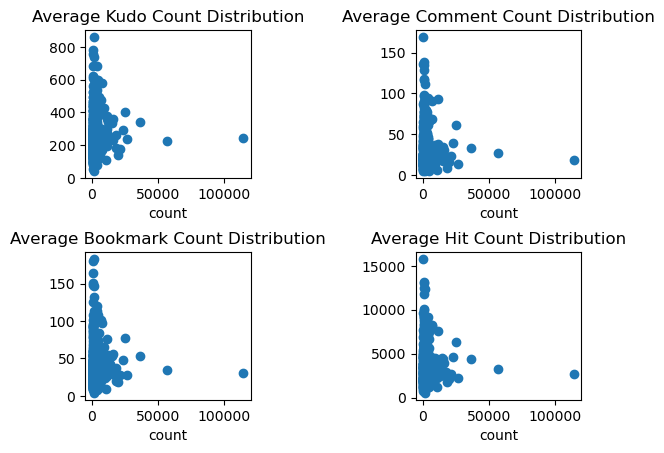

In [97]:
plt.subplot(2, 2, 1)
plt.scatter(counts, avg_kudos)
plt.title('Average Kudo Count Distribution')
plt.xlabel('count')
plt.subplot(2, 2, 2)
plt.scatter(counts, avg_comments)
plt.title('Average Comment Count Distribution')
plt.xlabel('count')
plt.subplot(2, 2, 3)
plt.scatter(counts, avg_bookmarks)
plt.title('Average Bookmark Count Distribution')
plt.xlabel('count')
plt.subplot(2, 2, 4)
plt.scatter(counts, avg_hits)
plt.title('Average Hit Count Distribution')
plt.xlabel('count')
plt.subplots_adjust(hspace=0.5, wspace=1)
plt.show()

Rather than being more skewed, it appears as if a higher count causes the popularity metrics to settle towards the average. 

Here are the highest rated tags for each popularity metric.

In [85]:
metrics = ['Overall Average Kudos', 'Overall Average Comments', 'Overall Average Bookmarks', 'Overall Average Hits']
view = filtered_tags_averages_df[['Name', 'Overall Average Kudos', 'Overall Average Comments', 'Overall Average Bookmarks', 'Overall Average Hits']]
for metric in metrics:
    display(view[['Name', metric]].sort_values(by = metric, ascending = False).head(10))
    

,Name,Overall Average Kudos
99,POV Outsider,658.491242
171,Alternate Universe - Time Travel,531.805423
139,Fix-It of Sorts,525.551005
306,Fix-It,478.528440
84,Bodyswap,467.658446
199,Team as Family,448.283865
165,Redemption,440.991899
35,Families of Choice,434.225621
25,Secret Identity,417.570671
107,Age Regression/De-Aging,416.835114


,Name,Overall Average Comments
139,Fix-It of Sorts,105.904556
157,Worldbuilding,102.442500
33,It Gets Worse Before It Gets Better,94.960648
171,Alternate Universe - Time Travel,93.648502
306,Fix-It,83.108280
25,Secret Identity,82.682867
20,Slow Burn,82.438102
165,Redemption,81.770454
23,Human Experimentation,74.043321
35,Families of Choice,73.978356


,Name,Overall Average Bookmarks
139,Fix-It of Sorts,121.769751
171,Alternate Universe - Time Travel,113.645971
99,POV Outsider,112.952738
306,Fix-It,109.931179
157,Worldbuilding,100.081714
199,Team as Family,90.173518
35,Families of Choice,89.148408
25,Secret Identity,85.921172
165,Redemption,85.213287
33,It Gets Worse Before It Gets Better,83.100463


,Name,Overall Average Hits
171,Alternate Universe - Time Travel,9083.886549
139,Fix-It of Sorts,8327.845968
33,It Gets Worse Before It Gets Better,8300.846347
157,Worldbuilding,7795.273084
306,Fix-It,7752.448220
165,Redemption,7680.877411
59,Character Development,7623.561806
1,Queerplatonic Relationships,7487.189014
23,Human Experimentation,7296.053943
25,Secret Identity,7059.505805


Here are the lowest rated tags for each popularity metric.

In [86]:
metrics = ['Overall Average Kudos', 'Overall Average Comments', 'Overall Average Bookmarks', 'Overall Average Hits']
view = filtered_tags_averages_df[['Name', 'Overall Average Kudos', 'Overall Average Comments', 'Overall Average Bookmarks', 'Overall Average Hits']]
for metric in metrics:
    display(view[['Name', metric]].sort_values(by = metric, ascending = True).head(10))
    

,Name,Overall Average Kudos
577,Podfic,52.624616
583,Poetry,70.952321
562,No Dialogue,87.432273
531,Songfic,88.698435
508,Inspired by Music,99.810605
586,Alternate Universe - Historical,102.046106
584,Modern Era,102.468161
585,Afterlife,106.546106
387,Sad Ending,108.735225
576,Reminiscing,110.680197


,Name,Overall Average Comments
562,No Dialogue,5.057398
408,Short One Shot,5.295459
222,Ficlet,6.166790
102,Short,6.737938
531,Songfic,6.941398
464,Tickling,7.003629
530,Short & Sweet,7.098728
561,Random & Short,7.186046
576,Reminiscing,7.187390
103,Drabble,7.561609


,Name,Overall Average Bookmarks
583,Poetry,7.429468
562,No Dialogue,8.025663
577,Podfic,8.730727
531,Songfic,9.568674
408,Short One Shot,9.704751
222,Ficlet,9.791042
561,Random & Short,9.915880
455,Gender-Neutral Pronouns,10.269796
103,Drabble,10.771119
102,Short,11.684786


,Name,Overall Average Hits
562,No Dialogue,865.168582
583,Poetry,915.548389
576,Reminiscing,1148.918678
222,Ficlet,1179.105534
531,Songfic,1196.071010
408,Short One Shot,1198.648393
585,Afterlife,1198.847611
508,Inspired by Music,1231.572079
561,Random & Short,1236.640284
579,New Year's Eve,1236.958776


# Data Modeling

While the above tables gives us a general idea of what tags are more influential than others, we would like to formally discover our anomalous tags. Since we are examining four different metrics, we have several options:

1. Examining each tag individually.
2. Examining all tags together.

## Viewing each metric individually

Outlier detection for 1-D data is fairly straightforward from the perspective of a normal distribution. However, above distributions have shown that the data is skewed right. In order to allow us to use outlier detection for normal distributions, we standardize our data using logarithmic transformations. Below is a before and after in terms of skew of our data:

In [113]:
std_tags_df = filtered_tags_averages_df[['Name','Overall Average Kudos', 'Overall Average Comments', 'Overall Average Bookmarks', 'Overall Average Hits']].copy(deep = True)
display(std_tags_df[['Overall Average Kudos', 'Overall Average Comments', 'Overall Average Bookmarks', 'Overall Average Hits']].skew())

std_tags_df['Overall Average Kudos'] = pd.DataFrame(np.log(std_tags_df['Overall Average Kudos'].values))
std_tags_df['Overall Average Comments'] = pd.DataFrame(np.log(std_tags_df['Overall Average Comments'].values))
std_tags_df['Overall Average Bookmarks'] = pd.DataFrame(np.log(std_tags_df['Overall Average Bookmarks'].values))
std_tags_df['Overall Average Hits'] = pd.DataFrame(np.log(std_tags_df['Overall Average Hits'].values))

display(std_tags_df[['Overall Average Kudos', 'Overall Average Comments', 'Overall Average Bookmarks', 'Overall Average Hits']].skew())


Overall Average Kudos        1.237835
Overall Average Comments     1.649197
Overall Average Bookmarks    1.726134
Overall Average Hits         1.244787
dtype: float64

Overall Average Kudos       -0.093150
Overall Average Comments     0.032980
Overall Average Bookmarks    0.043384
Overall Average Hits         0.063218
dtype: float64

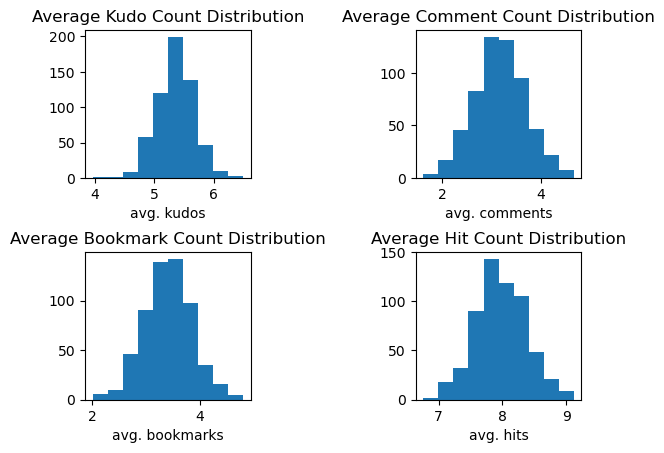

In [123]:
plt.subplot(2, 2, 1)
plt.hist(std_tags_df['Overall Average Kudos'].values)
plt.title('Average Kudo Count Distribution')
plt.xlabel('avg. kudos')
plt.subplot(2, 2, 2)
plt.hist(std_tags_df['Overall Average Comments'].values)
plt.title('Average Comment Count Distribution')
plt.xlabel('avg. comments')
plt.subplot(2, 2, 3)
plt.hist(std_tags_df['Overall Average Bookmarks'].values)
plt.title('Average Bookmark Count Distribution')
plt.xlabel('avg. bookmarks')
plt.subplot(2, 2, 4)
plt.hist(std_tags_df['Overall Average Hits'].values)
plt.title('Average Hit Count Distribution')
plt.xlabel('avg. hits')
plt.subplots_adjust(hspace=0.5, wspace=1)
plt.show()

Now we can examine tags considered anomalies according to their z-scores. The mininum z-score absolute value can be adjusted below.

In [181]:
from scipy import stats

min_zscore = 3

display(filtered_tags_averages_df.iloc[np.where(np.abs(stats.zscore(std_tags_df['Overall Average Kudos'].values)) > min_zscore)][['Name', 'Total Count', 'Overall Average Kudos']])
display(filtered_tags_averages_df.iloc[np.where(np.abs(stats.zscore(std_tags_df['Overall Average Comments'].values)) > min_zscore)][['Name', 'Total Count', 'Overall Average Comments']])
display(filtered_tags_averages_df.iloc[np.where(np.abs(stats.zscore(std_tags_df['Overall Average Bookmarks'].values)) > min_zscore)][['Name', 'Total Count', 'Overall Average Bookmarks']])
display(filtered_tags_averages_df.iloc[np.where(np.abs(stats.zscore(std_tags_df['Overall Average Hits'].values)) > min_zscore)][['Name', 'Total Count', 'Overall Average Hits']])

,Name,Total Count,Overall Average Kudos
99,POV Outsider,1187,658.491242
577,Podfic,746,52.624616
583,Poetry,1424,70.952321


,Name,Total Count,Overall Average Comments


,Name,Total Count,Overall Average Bookmarks
139,Fix-It of Sorts,961,121.769751
583,Poetry,1424,7.429468


,Name,Total Count,Overall Average Hits
562,No Dialogue,578,865.168582


## Viewing Tags Together

We will use DBScan to determine if there are any notable outliers.

These offer a different view of an "outlier", as this is based on a clustering algorithm. This simply shows tags that have holistically different behavior between the four metrics in comparison with other tags.

In [177]:
from sklearn.cluster import DBSCAN
db_classifier = DBSCAN(eps = 0.3, min_samples = 2)

metrics = ['Overall Average Kudos', 'Overall Average Comments', 'Overall Average Bookmarks', 'Overall Average Hits']

X = std_tags_df[metrics].values

db_classifier.fit(X)
labels = db_classifier.labels_
# Show noisy tags
display(filtered_tags_averages_df[['Name', 'Total Count', 'Overall Average Kudos', 'Overall Average Comments', 'Overall Average Bookmarks', 'Overall Average Hits']].iloc[np.where(labels == -1)])


,Name,Total Count,Overall Average Kudos,Overall Average Comments,Overall Average Bookmarks,Overall Average Hits
99,POV Outsider,1187,658.491242,35.827110,112.952738,5382.182365
455,Gender-Neutral Pronouns,1350,122.273292,9.770619,10.269796,1936.393484
562,No Dialogue,578,87.432273,5.057398,8.025663,865.168582
577,Podfic,746,52.624616,8.346468,8.730727,1588.922090
583,Poetry,1424,70.952321,8.635917,7.429468,915.548389


# Concluding Remarks

Overall, these two methods have some overlap. It is difficult to draw any anecdotal insight without consulting someone who actively reads fanfiction, but it is interesting to see a general theme in these outliers. 

From what can be seen, however, it appears as if the tag "POV Outsider" is overall one of the more influential tags in terms of raising Kudo count, while tags like "Poetry" and "No Dialogue" can be viewed as generally unpopular.